# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using Statistics

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

Given $n$ independent samples, we simulate phenotypes from 
$$\mathbf{y}_i \sim QC(\mathbf{\Gamma}, f_1, ..., f_d)$$

In [21]:
# simulate data
p = 3    # number of fixed effects, including intercept
m = 2    # number of variance componentsac
n = 1000 # number of sample
d = 5    # number of phenotypes per sample
q = 1000 # number of SNPs
k = 0   # number of causal SNPs

# sample d marginal distributions for each phenotype within samples
Random.seed!(2022)
possible_distributions = [Bernoulli, Normal]
vecdist = rand(possible_distributions, d)
veclink = [canonicallink(vecdist[j]()) for j in 1:d]

# simulate nongenetic coefficient and variance component params
Random.seed!(2022)
Btrue = rand(Uniform(-2, 2), p, d)
θtrue = [0.5, 0.5]
V1 = ones(d, d)
V2 = Matrix(I, d, d)
Γ = θtrue[1] * V1 + θtrue[2] * V2

# simulate non-genetic design matrix
Random.seed!(2022)
X = [ones(n) randn(n, p - 1)]

# simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
Random.seed!(2022)
G = simulate_random_snparray(undef, n, q)
Gfloat = convert(Matrix{Float64}, G, center=true, scale=true)
γtrue = zeros(q, d)
causal_snps = sample(1:q, k, replace=false) |> sort
for j in 1:d
    γtrue[causal_snps, j] .= rand([-1, 1], k)
end

# sample phenotypes
Y = zeros(n, d)
y = Vector{Float64}(undef, d)
for i in 1:n
    Xi = X[i, :]
    Gi = Gfloat[i, :]
    η = Btrue' * Xi + γtrue' * Gi
    vecd_tmp = Vector{UnivariateDistribution}(undef, d)
    for j in 1:d
        dist = vecdist[j]
        μj = GLM.linkinv(canonicallink(dist()), η[j])
        vecd_tmp[j] = dist(μj)
    end
    multivariate_dist = MultivariateMix(vecd_tmp, Γ)
    res = Vector{Float64}(undef, d)
    rand(multivariate_dist, y, res)
    Y[i, :] .= y
end

# form model
V = m == 1 ? [V1] : [V1, V2]
gcm = MultivariateCopulaVCModel(Y, X, V, vecdist, veclink)

[gcm.Y[3, :] vecdist]

5×2 Matrix{Any}:
  1.0       Bernoulli
  0.259505  Normal
  0.167591  Normal
 -1.53291   Normal
 -0.810204  Normal

In [22]:
Statistics.cor(Y)

5×5 Matrix{Float64}:
  1.0         0.275572  -0.040037  -0.0457656  -0.209217
  0.275572    1.0       -0.584824  -0.292932   -0.724279
 -0.040037   -0.584824   1.0        0.284534    0.639341
 -0.0457656  -0.292932   0.284534   1.0         0.420253
 -0.209217   -0.724279   0.639341   0.420253    1.0

## Fit Null model

TODO: 

+ Initializing model parameters
+ Fix score test R/W/Q calculations

In [25]:
fittime = @elapsed QuasiCopula.fit!(gcm)
@show fittime
@show gcm.β
@show gcm.θ
@show gcm.∇β
@show gcm.∇θ;

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0



LoadError: UndefVarError: fdsa not defined

In [5]:
@show Btrue
@show θtrue;

Btrue = [-1.1230213356091427 -0.1877649227559921 0.5791362601004253 -0.9381371993307428 0.35275770693929287; 0.6704123494545922 1.9335348455113577 -1.5709582151146102 -0.3878936938977797 -1.7342422013453889; -1.323982816165533 -1.0766183810582235 0.10434699949207227 0.3821407054225814 1.0014775101600586]
θtrue = [0.5, 0.5]


## Score test

In [36]:
loglikelihood!(gcm, true, true)
@time pvals = QuasiCopula.GWASCopulaVCModel(gcm, G)

S = -14.144181648377065, Q = -10656.51257327203, W'*Pinv*W = -39.67435544562029
S = -13.14909042682002, Q = -11237.91251588582, W'*Pinv*W = -3.8401244429677983
S = -0.35767106910934904, Q = -12416.293474583323, W'*Pinv*W = -69.97975628979637
S = -23.223642324817884, Q = -10825.398508290626, W'*Pinv*W = -54.02855745231168
S = -9.689058579916853, Q = -8667.377526619799, W'*Pinv*W = -11.44597937017479
S = -1.3760141548010874, Q = -11838.80196065003, W'*Pinv*W = -38.800310821640814
S = -4.772022366817989, Q = -11255.156010628962, W'*Pinv*W = -12.93870995458434
S = -62.46566586158536, Q = -10778.245275359874, W'*Pinv*W = -1.8156501087890216
S = -3.9848124235376656, Q = -9984.625210173725, W'*Pinv*W = -128.0168931734168
S = -3.8476472970482143, Q = -10915.116706269928, W'*Pinv*W = -5.271248270812332
S = -22.695012814182476, Q = -11046.693665772656, W'*Pinv*W = -9.775594271904588
  0.028456 seconds (451.43 k allocations: 15.722 MiB)


10000-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [25]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / length(correct_snps)

@show length(signif_snps)
@show power

length(signif_snps) = 2372
power = 1.0


1.0

In [26]:
pvals[correct_snps] |> sort

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.4306456321992478e-306
 2.813561675451958e-280
 1.1407938402822702e-244
 3.008283957133946e-162

In [27]:
sort(pvals)

10000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.4306456321992478e-306
 2.813561675451958e-280
 1.1407938402822702e-244
 3.008283957133946e-162
 1.9692865151530085e-53
 9.151400483740179e-48
 7.922637364708374e-46
 ⋮
 0.9948637729778123
 0.995812432050593
 0.997203779990465
 0.9988408359939452
 0.9989691684594109
 0.9991227856302899
 0.999261523363882
 0.9992715388476073
 0.9993072173731976
 0.9993617459162504
 0.9996781120351591
 0.9999788751927675

## QQ Plots

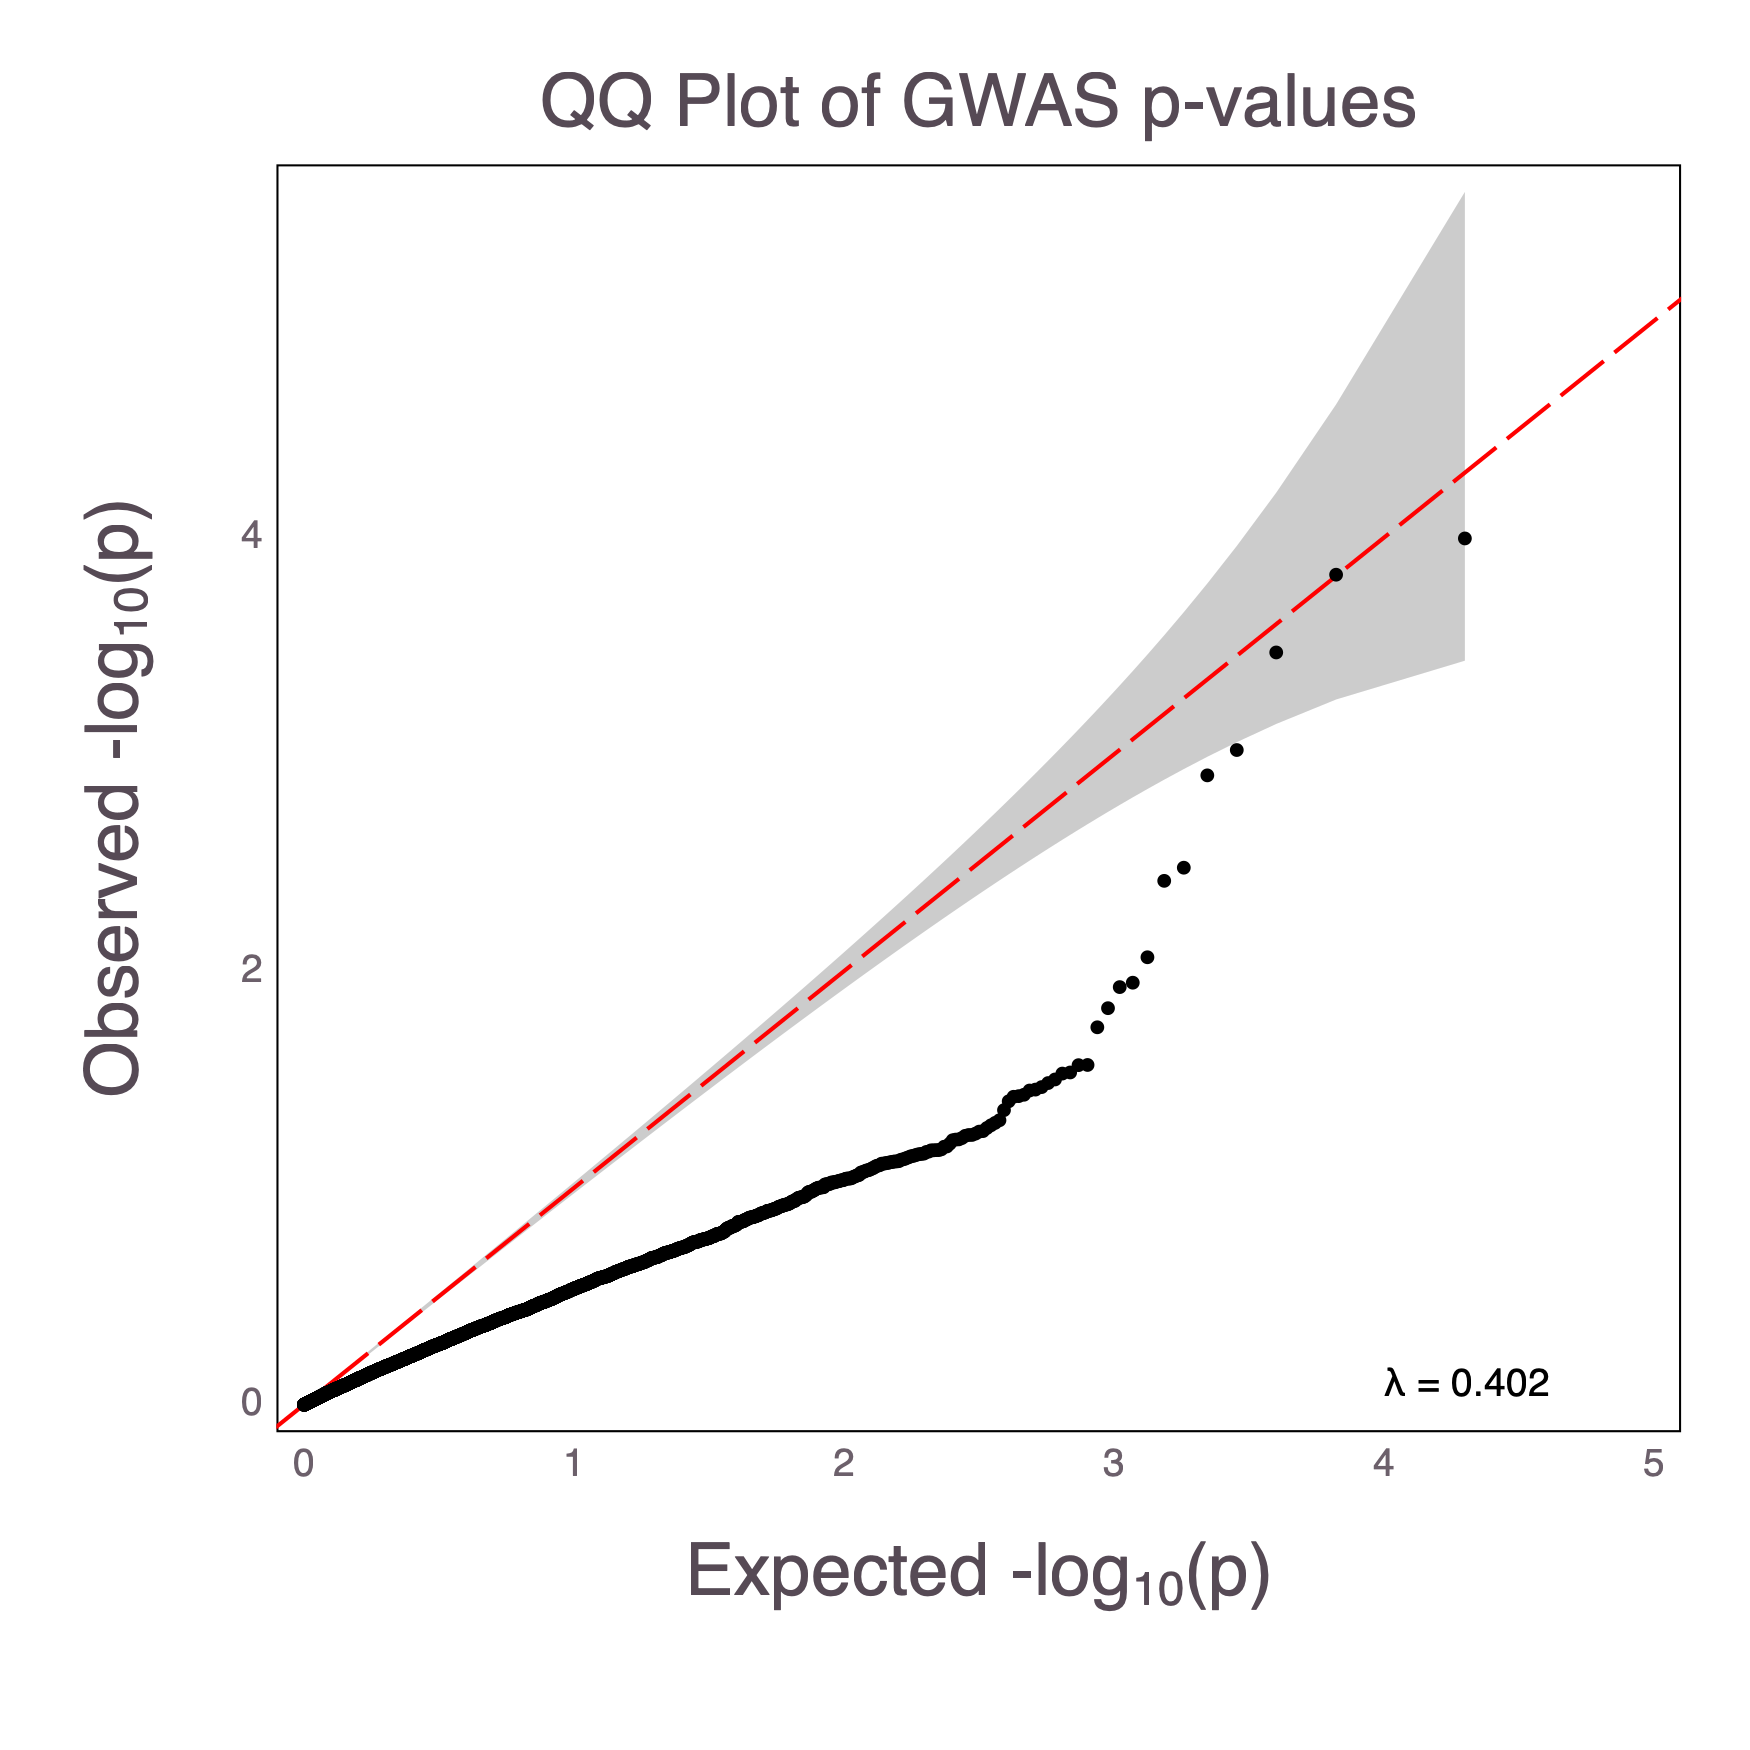

In [34]:
# this has to be done in terminal
using MendelPlots
qq(pvals)
display("image/png", read("qqplot.png"))